<a href="https://colab.research.google.com/github/Adronz/Needle-Segmentation/blob/main/NeedleSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from transformers import AutoImageProcessor, ViTMAEForPreTraining, ViTFeatureExtractor, ViTImageProcessor

from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim
# import torch.nn as nn
from PIL import Image

#for trainer
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device is {device}')

processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
image_dir = '/content/gdrive/MyDrive/trainImages'
mask_dir = '/content/gdrive/MyDrive/trainMasks'

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)



In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
class SAMDataset(Dataset):
  def __init__(self, image_path, mask_path, processor, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform


    # List all files in the image_dir assuming files are named as '1344.jpg'
    self.filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
#     self.filenames.sort()  # Sort files to maintain order


    self.processor = processor

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):

    #FROM NEEDLE DATASET CLASS
    img_name = self.filenames[idx]
    img_path = os.path.join(self.image_dir, img_name)

    # Corresponding mask file, assuming mask files are named '1342_mask.jpg'
    mask_name = img_name.split('.')[0] + '_mask.png'
    mask_path = os.path.join(self.mask_dir, mask_name)


    #FROM THIS BS
    # item = self.dataset[idx]
    image = Image.open(img_path).convert('RGB')

    #for normalization of image
    m, s = np.mean(image, axis=(0, 1)), np.std(image, axis=(0, 1))


    ###########
    # ###########

    #preprocess images
    image = image.resize((256, 256))
    image_np = np.array(image)
    image_tensor = torch.from_numpy(image_np).float()
    image_tensor = image_tensor.permute(1,2,0)
    norm_image = transforms.Normalize(mean=m, std=s)

    #preprocess masks
    ground_truth_mask = Image.open(mask_path).convert('L')
    ground_truth_mask = ground_truth_mask.resize((256, 256))

    ground_truth_mask = np.array(ground_truth_mask)


    # get bounding box prompt
    if np.any(ground_truth_mask):
    # If the mask is not empty, get bounding box
       prompt = get_bounding_box(ground_truth_mask)
    else:
    # Define a default prompt or handling for empty masks
       prompt = [0, 0, 1, 1]  # Example: a minimal default box or similar appropriate value



    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")


    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask


    return inputs

# transform = transforms.Compose([
# transforms.Resize((256, 256)),
# transforms.ToTensor(),
# transforms.Normalize(mean=m, std=s)
# ])

In [ ]:
!pip -q install datasets
from datasets import load_dataset

image_data = load_dataset(image_dir, split='train')
mask_data = load_dataset(mask_dir, split='train')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 40.7 MB/s eta 0:00:00


Resolving data files:   0%|          | 0/505 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/515 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#this is from the old one i hope it works better
train_dataset = SAMDataset(image_dir, mask_dir, processor=processor)



In [ ]:
train_dataset[0]

{'pixel_values': tensor([[[-1.4500, -1.4500, -1.4500,  ..., -1.4329, -1.4329, -1.4329],
          [-1.4500, -1.4500, -1.4500,  ..., -1.4329, -1.4329, -1.4329],
          [-1.4500, -1.4500, -1.4500,  ..., -1.4329, -1.4329, -1.4329],
          ...,
          [-1.1760, -1.1760, -1.1932,  ...,  1.1358,  1.1358,  1.1358],
          [-1.1760, -1.1760, -1.1932,  ...,  1.1187,  1.1187,  1.1187],
          [-1.1760, -1.1760, -1.1932,  ...,  1.1187,  1.1187,  1.1187]],
 
         [[-1.3529, -1.3529, -1.3529,  ..., -1.3354, -1.3354, -1.3354],
          [-1.3529, -1.3529, -1.3529,  ..., -1.3354, -1.3354, -1.3354],
          [-1.3529, -1.3529, -1.3529,  ..., -1.3354, -1.3354, -1.3354],
          ...,
          [-1.0728, -1.0728, -1.0903,  ...,  1.2906,  1.2906,  1.2906],
          [-1.0728, -1.0728, -1.0903,  ...,  1.2731,  1.2731,  1.2731],
          [-1.0728, -1.0728, -1.0903,  ...,  1.2731,  1.2731,  1.2731]],
 
         [[-1.1247, -1.1247, -1.1247,  ..., -1.1073, -1.1073, -1.1073],
          [-

In [ ]:
# train_dataset[0]['ground_truth_mask'].shape

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)  # Check the output shapes


pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [ ]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
!pip install -q monai
import monai
# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=8e-4, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    counter = 0
    for batch in tqdm(train_dataloader):
      # input_min = batch["pixel_values"].min().item()
      # input_max = batch["pixel_values"].max().item()
      # print(f'input image min: {input_min} Max: {input_max}')

      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      # print(f'predicted mask shape {predicted_masks.shape}')

      # Normalize ground truth masks to be in the range [0, 1]
      ground_truth_masks = batch["ground_truth_mask"].float().to(device) / 255.0
      # print(f'ground truth mask shape {ground_truth_masks.shape}')

      # print("Model Outputs Min:", predicted_masks.min().item(), "Max:", predicted_masks.max().item())
      # print("Ground Truth Min:", ground_truth_masks.min().item(), "Max:", ground_truth_masks.max().item())

      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 101/101 [06:53<00:00,  4.09s/it]


EPOCH: 0
Mean loss: 0.628034924221511


100%|██████████| 101/101 [01:28<00:00,  1.14it/s]


EPOCH: 1
Mean loss: 0.33846423131330766


100%|██████████| 101/101 [01:28<00:00,  1.14it/s]


EPOCH: 2
Mean loss: 0.2983657311242406


100%|██████████| 101/101 [01:28<00:00,  1.14it/s]


EPOCH: 3
Mean loss: 0.29366255889065784


100%|██████████| 101/101 [01:28<00:00,  1.14it/s]


EPOCH: 4
Mean loss: 0.29078324021089197


100%|██████████| 101/101 [01:25<00:00,  1.18it/s]


EPOCH: 5
Mean loss: 0.284630702605637


100%|██████████| 101/101 [01:25<00:00,  1.18it/s]


EPOCH: 6
Mean loss: 0.2703942148992331


100%|██████████| 101/101 [01:25<00:00,  1.18it/s]


EPOCH: 7
Mean loss: 0.26291818784015014


100%|██████████| 101/101 [01:25<00:00,  1.18it/s]


EPOCH: 8
Mean loss: 0.2510168313758798


100%|██████████| 101/101 [01:25<00:00,  1.18it/s]

EPOCH: 9
Mean loss: 0.24658524079045446


In [ ]:
from google.colab import files

# Assuming `model` is your trained model
# Define the path to save the model
model_path = "NeedleSAM.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Download the model file to your local machine
files.download(model_path)

Model saved to NeedleSAM_Colab.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

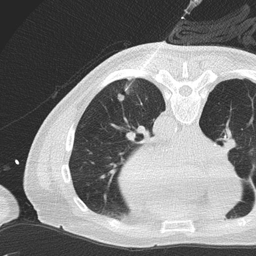

In [ ]:
# let's take a random training example
idx = 0

# load image
image = image_data[idx]["image"].resize((256,256)).convert('RGB')
image

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)  # Check the output shapes


pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [ ]:
model.eval()

model.to(device)
# forward pass
with torch.no_grad():
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)




In [ ]:
batch['ground_truth_mask'][2].shape

torch.Size([256, 256])

Shape of original image 0: (1024, 1024, 3)
Shape of predicted mask 0: (256, 256)
Shape of ground truth mask 0: torch.Size([256, 256])


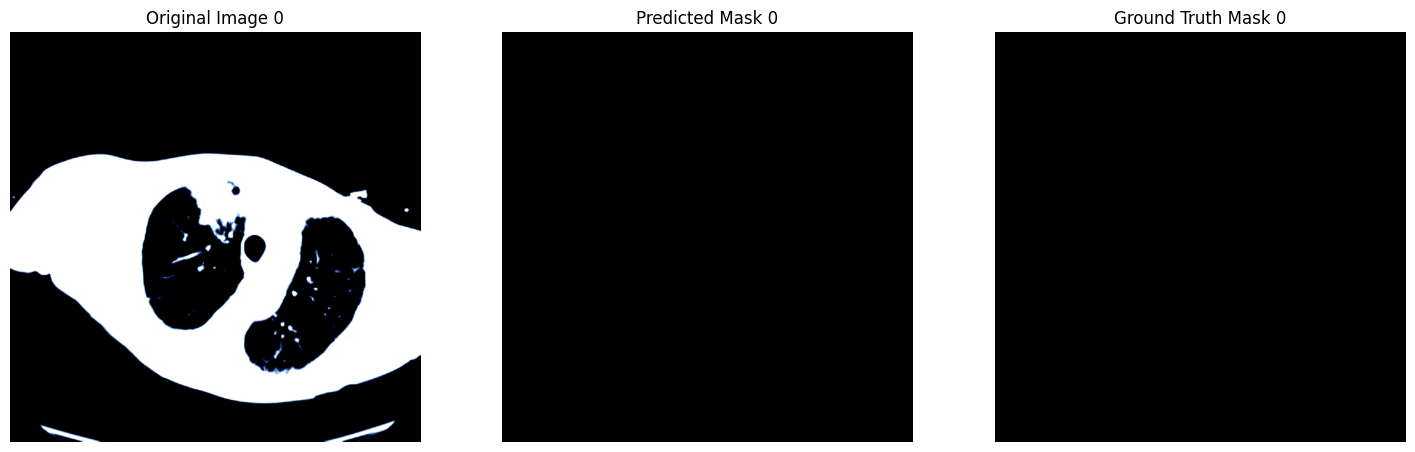

Shape of original image 1: (1024, 1024, 3)
Shape of predicted mask 1: (256, 256)
Shape of ground truth mask 1: torch.Size([256, 256])


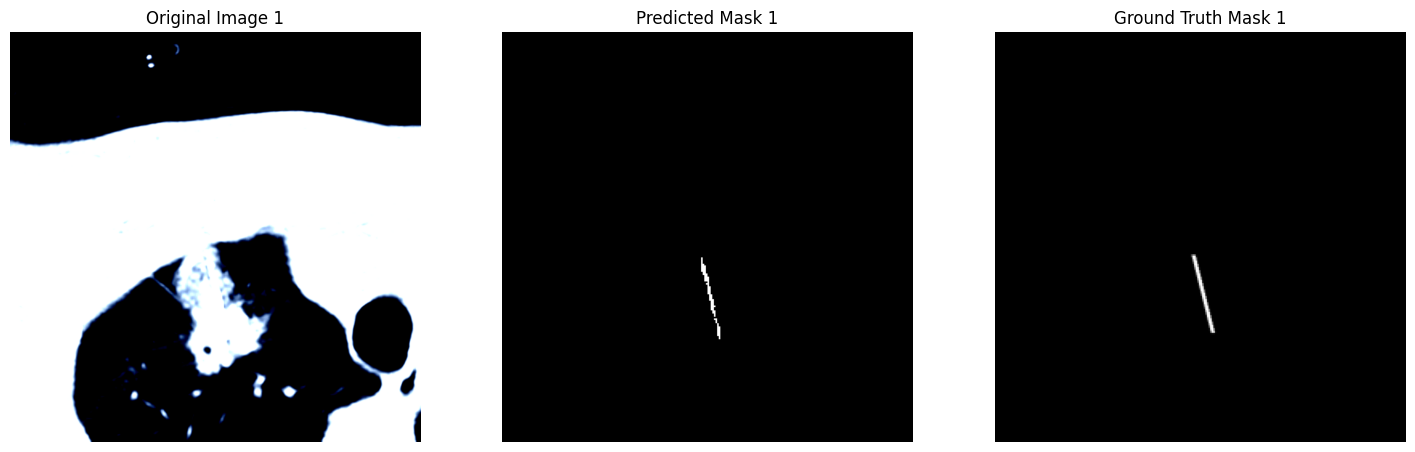

Shape of original image 2: (1024, 1024, 3)
Shape of predicted mask 2: (256, 256)
Shape of ground truth mask 2: torch.Size([256, 256])


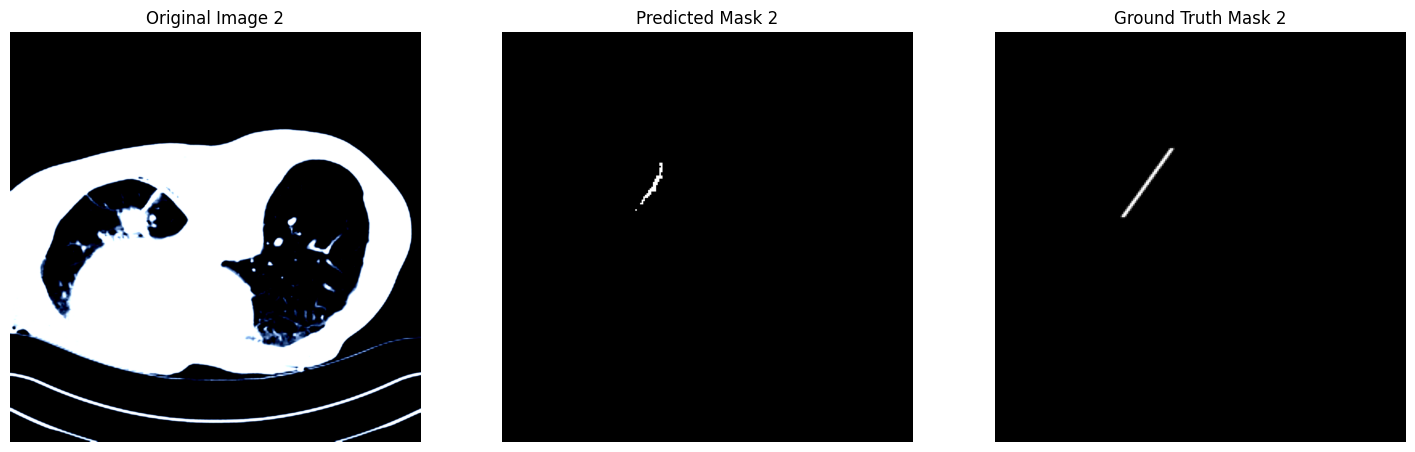

Shape of original image 3: (1024, 1024, 3)
Shape of predicted mask 3: (256, 256)
Shape of ground truth mask 3: torch.Size([256, 256])


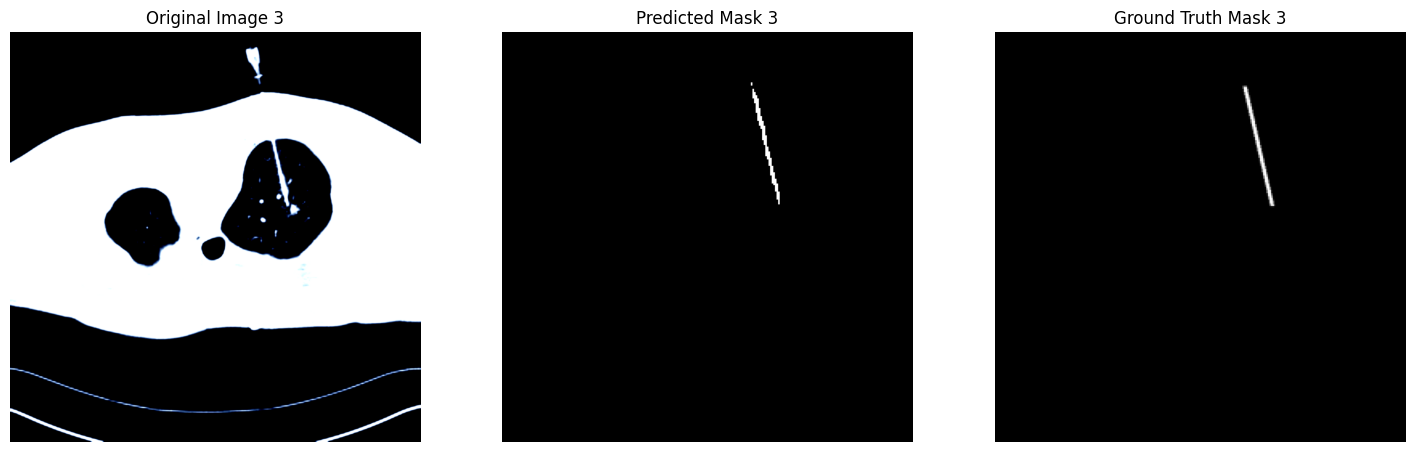

Shape of original image 4: (1024, 1024, 3)
Shape of predicted mask 4: (256, 256)
Shape of ground truth mask 4: torch.Size([256, 256])


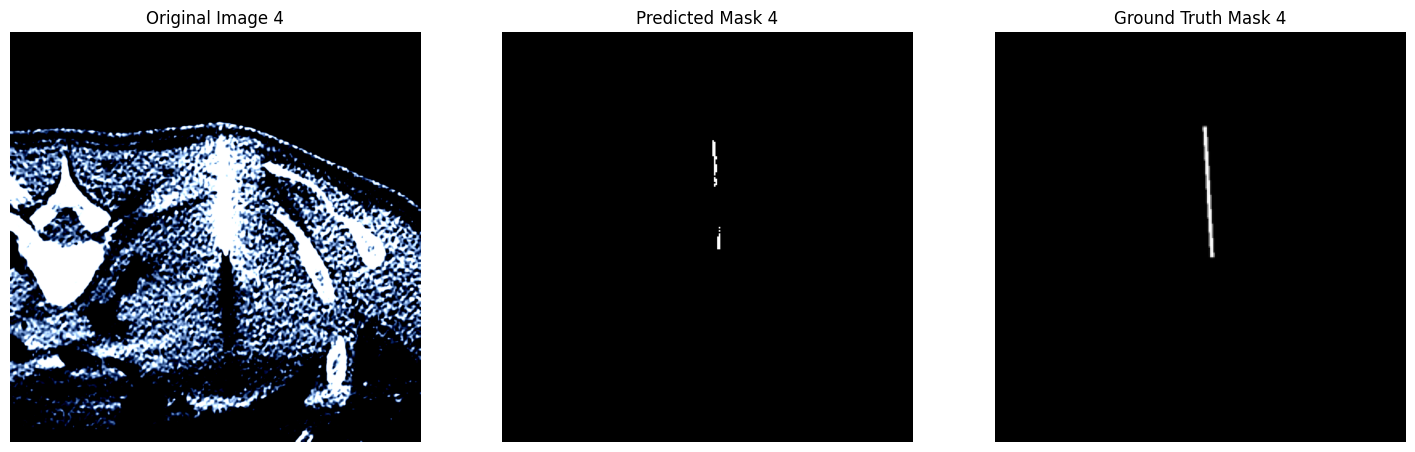

In [ ]:
batch_size = outputs.pred_masks.shape[0]
ground_truth_mask = batch["ground_truth_mask"]
# medsam_seg_probs = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_probs = outputs.pred_masks.squeeze(1)

for i in range(batch_size):
    # Get the i-th original image, predicted mask, and ground truth mask
    original_image = batch["pixel_values"][i].permute(1, 2, 0).detach().cpu().numpy()
    medsam_seg_prob = medsam_seg_probs[i].squeeze(0).detach().cpu().numpy()
    # ground_truth_mask = ground_truth_mask[i].squeeze().detach().cpu().numpy()
    ground_truth_mask = batch['ground_truth_mask'][i]
    # Convert soft mask to hard mask
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # Check the shape to ensure it is correct for visualization
    print(f"Shape of original image {i}: {original_image.shape}")  # Should be (height, width, channels)
    print(f"Shape of predicted mask {i}: {medsam_seg.shape}")  # Should be (height, width)
    print(f"Shape of ground truth mask {i}: {ground_truth_mask.shape}")  # Should be (height, width)

    # Plot the original image, predicted mask, and ground truth mask side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original Image {i}')
    axes[0].axis('off')  # Hide axes for a cleaner look

    axes[1].imshow(medsam_seg, cmap='gray')
    axes[1].set_title(f'Predicted Mask {i}')
    axes[1].axis('off')  # Hide axes for a cleaner look

    axes[2].imshow(ground_truth_mask, cmap='gray')
    axes[2].set_title(f'Ground Truth Mask {i}')
    axes[2].axis('off')  # Hide axes for a cleaner look

    plt.show()

## Generalize to test data

In [ ]:

"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()
# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)


print(np.array(input_points).shape)

(1, 1, 100, 2)


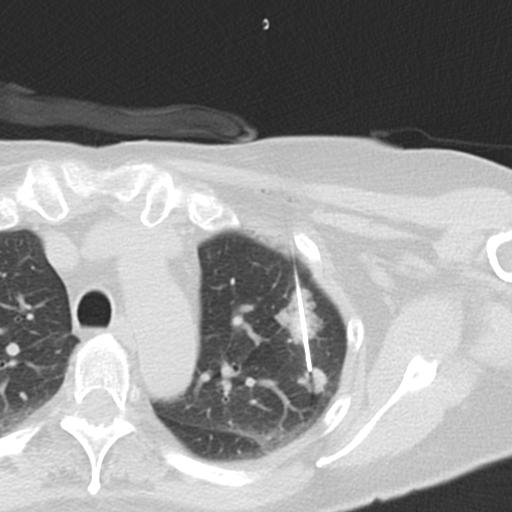

In [ ]:
image_data[8]['image']

torch.Size([256, 256, 3])


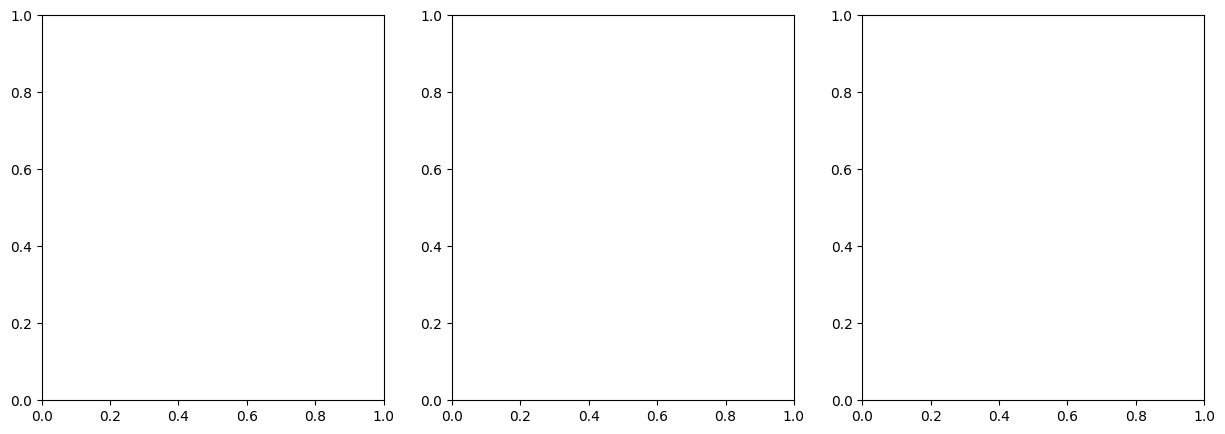

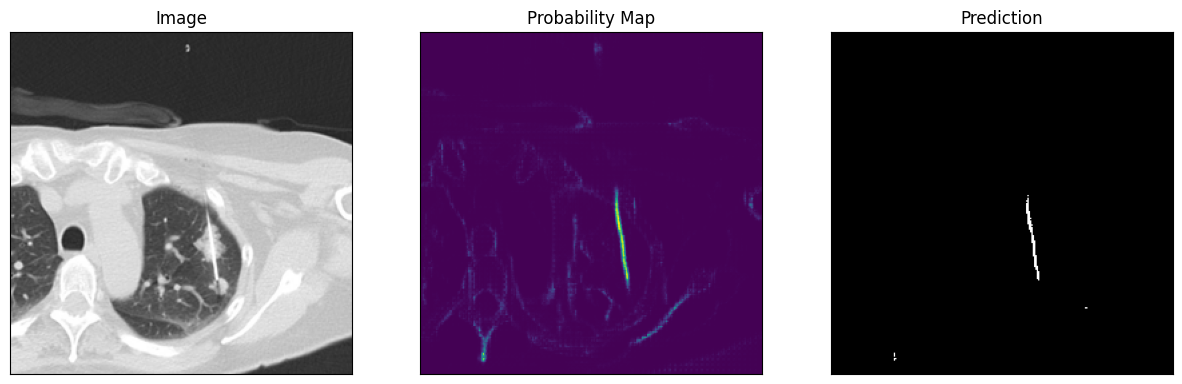

In [ ]:

# # Select a random patch for segmentation

# # Compute the total number of 256x256 arrays
# #num_arrays = patches.shape[0] * patches.shape[1]
# # Select a random index
# #index = np.random.choice(num_arrays)
# # Compute the indices in the original array
# #i = index // patches.shape[1]
# #j = index % patches.shape[1]

# #Or pick a specific patch for study.
# i, j = 1, 2

# # Selectelected patch for segmentation
# random_array = patches[i, j]


# single_patch = Image.fromarray(random_array)
# # prepare image for the model

# #First try without providing any prompt (no bounding box or input_points)
# #inputs = processor(single_patch, return_tensors="pt")
# #Now try with bounding boxes. Remember to uncomment.


image = image_data[8]['image']
image = image.convert("RGB")
m, s = np.mean(image, axis=(0, 1)), np.std(image, axis=(0, 1))
image = image.resize((256, 256))
image_np = np.array(image)
image_tensor = torch.from_numpy(image_np).float()
# image_tensor = image_tensor.permute(1,2,0)
print(image_tensor.shape)

# norm_image = transforms.Normalize(mean=m, std=s)
#We will just use a single image instead of patchifying
inputs = processor(image_tensor, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
model.eval()


# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
# Unmount Google Drive if already mounted
drive.flush_and_unmount()

# Wait for a few seconds to ensure the unmount process completes
import time
time.sleep(5)

# Remount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
test_dir = '/content/gdrive/MyDrive/testImages'

In [ ]:
class SortedImageDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.png')], key=self.extract_file_number)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert("RGB")

        # Extract the file number from the filename
        file_number = self.extract_file_number(img_name)

        return file_number, image

    def extract_file_number(self, filename):
        # Extract the numerical part of the filename
        return int(os.path.splitext(filename)[0])

In [ ]:
sorted_image_dataset = SortedImageDataset(folder_path=test_dir)
test_dataloader = DataLoader(sorted_image_dataset, batch_size=1, shuffle=False)

## Produce test image masks

In [ ]:
model.eval()
with torch.no_grad():
  for file_number, input_image in test_dataloader:
      print(f"Processing file number: {file_number.item()}")
      image = input_image
      image = image.convert("RGB")
      m, s = np.mean(image, axis=(0, 1)), np.std(image, axis=(0, 1))
      image = image.resize((256, 256))
      image_np = np.array(image)
      image_tensor = torch.from_numpy(image_np).float()
      # image_tensor = image_tensor.permute(1,2,0)
      # print(image_tensor.shape)
      # norm_image = transforms.Normalize(mean=m, std=s)
      #We will just use a single image instead of patchifying

      inputs = processor(image_tensor, input_points=input_points, return_tensors="pt")

      # Move the input tensor to the GPU if it's not already there
      inputs = {k: v.to(device) for k, v in inputs.items()}

      outputs = model(**inputs, multimask_output=False)


      # Assume the model output is a single channel mask (e.g., binary or grayscale)
      mask = outputs.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
      # Convert mask to an image
      mask = (mask * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
      mask_image = Image.fromarray(mask)

      # Save the mask image
      mask_image.save(os.path.join('/Users/AdrianHanson/Desktop/Imaging Informatics/output_masks', f'{file_numbe.item()}.png'))

      print("Processing complete. Masks saved to", '/Users/AdrianHanson/Desktop/Imaging Informatics/output_masks')
